In [1]:
!pip install Pillow --quiet
!pip install webdataset==0.1.62
!pip install pytorch-model-summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.models as models
import torchvision.transforms as T
import numpy as np
import h5py
import os
import sys
import datetime
import csv

import torchvision
from torchvision import transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import logging
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset

# For visualize input
from torch.utils.tensorboard import SummaryWriter
import io
import torchvision
from torchvision import transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
from PIL import Image

In [3]:
import webdataset as wds
from itertools import islice
import struct, ast
from importlib_metadata import version

In [4]:
version('webdataset')

'0.1.62'

In [5]:
class Logger():
    def __init__(self, mode='log'):
        self.mode = mode
        
    def set_model_save_location(self, model_dir):
        self.model_dir = f"saved-model/{model_dir}"
        
    def set_experiment(self, experiment_name):
        self.experiment_name = experiment_name
        log_format = '%(asctime)s %(message)s'
        logging.basicConfig(stream=sys.stdout, level=logging.INFO,
                            format=log_format, datefmt='%m/%d %I:%M:%S %p')
        fh = logging.FileHandler(os.path.join('training-logs', f'log-{experiment_name}-{datetime.datetime.today()}.txt'))
        fh.setFormatter(logging.Formatter(log_format))
        logging.getLogger().addHandler(fh)
        self.writer = SummaryWriter(f"runs/{experiment_name}")
            
    def log(self, message=""):
        if self.mode == 'log':
            logging.info(message)
        elif self.mode == 'debug':
            print(message)

    def save_model(self, model, info):
        torch.save(model.state_dict(), f"{self.model_dir}/model-{self.experiment_name}-{info}")
        
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

def add_chan_dim(x):
    x = torch.tensor(x)
#     x = torch.transpose(x, 0, 1)
    return torch.unsqueeze(x,0)


def selectLabel(x,lbl):
    # # function to select desired label
    lbl_idx = ["id","sex","age","handedness","index"].index(lbl.lower())
    x = x.decode("utf-8").split(",")
    # return x if lbl_idx == 0 else float(x)
    return 1
    
s3_url = 'https://childmind.s3.us-west-1.amazonaws.com/python/childmind_train.tar' # replace 'train' with 'val' and 'test' accordingly
train_data = wds.WebDataset(s3_url).decode().map_dict(npy=add_chan_dim, cls=lambda x: selectLabel(x,'sex')).to_tuple("npy","cls")

s3_url = 'https://childmind.s3.us-west-1.amazonaws.com/python/childmind_val.tar' # replace 'train' with 'val' and 'test' accordingly
val_data = wds.WebDataset(s3_url).decode().map_dict(npy=add_chan_dim, cls=lambda x: selectLabel(x,'sex')).to_tuple("npy","cls")

using device: cuda


In [11]:
class VAE(nn.Module): 
    
    def __init__(self, latent_dim):
        # latent_dim: dimension of the latent representation vector
        super().__init__()
        self.latent_dim = latent_dim
        self.beta = 4
        self.gamma = 1000.
        self.loss_type = 'H'
        self.C_max = torch.tensor([25])
        self.C_stop_iter = 1e5

        encoder_l = [self.encoder_conv_block(True)]
        for i in range(2):
            encoder_l.append(self.encoder_conv_block())
        encoder_l.append(self.encoder_conv_block(False, 32, 32, 3, 1, 0))
        encoder_l.append(nn.Flatten())
        self.encoder_before_last = nn.ModuleList(encoder_l)
        self.encoder_mu = self.encoder_linear_block(960, latent_dim)
        self.encoder_log_var = self.encoder_linear_block(960, latent_dim)
                            
        decoder_l = [self.decoder_linear_block(latent_dim, 960)]
        decoder_l.append(self.decoder_conv_block(False, 32, 32, 3, 1, 0))
        for i in range(2):
            decoder_l.append(self.decoder_conv_block())
        decoder_l.append(self.decoder_conv_block(True))
        self.decoder = nn.ModuleList(decoder_l)
    
    def encoder_conv_block(self, is_start=False, in_channels=32, out_channels=32, kernel_size=6, stride=2, padding=2):
        if is_start:
            return nn.Sequential(
                nn.Conv2d(1, out_channels, kernel_size, stride, padding),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU()
            )
        else:
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU()
            )
    def encoder_linear_block(self, in_chan, out_chan):
        return nn.Sequential(
            nn.Linear(in_chan, out_chan)
        )
    
    def decoder_conv_block(self, is_last=False, in_channels=32, out_channels=32, kernel_size=6, stride=2, padding=2):
        if is_last:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, 1, kernel_size, stride, padding),
                nn.BatchNorm2d(1),
                nn.LeakyReLU()
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU()
            )
    
    def decoder_linear_block(self, in_chan, out_chan):
        return nn.Sequential(
            nn.Linear(in_chan, out_chan),
            nn.ReLU()
        )
    
    def forward(self, x):
        for f in self.encoder_before_last:
            x = f(x)

        mu = self.encoder_mu(x)
        log_var = self.encoder_log_var(x)

        z = self.reparameterize(mu, log_var)
        
        x = self.decoder[0](z)
        x = x.view(-1, 32, 1, 30) # reshape the tensor to be expected dimension for ConvTranspose
        for i in range(1,len(self.decoder)):
            f = self.decoder[i]
            x = f(x) 
            
        return x, mu, log_var
    
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling
        return sample

    def sample_z(self, mu, sigma):
        # Input
        #     mu:     [batch_size, self.latent_size] the predicted mu value for each sample in the batch
        #     sigma:  [batch_size, self.latent_size] the predicted diag elem of sigma value for each sample in the batch
        # Output
        #     z: [batch_size, self.latent_size] the latent representation of each sample in the batch
        # Reference: https://agustinus.kristia.de/techblog/2016/12/10/variational-autoencoder/
        
        # eps ~ N(0,1)        
        batch_size = mu.size()[0]
        eps = torch.randn((batch_size,1), device=device, dtype=dtype)
        z = mu + sigma/2*eps
        
        return z

    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]
        kld_weight = kwargs['M_N']  # Account for the minibatch samples from the dataset

        recons_loss =F.mse_loss(recons, input)

        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        if self.loss_type == 'H': # https://openreview.net/forum?id=Sy2fzU9gl
            loss = recons_loss + self.beta * kld_weight * kld_loss
        elif self.loss_type == 'B': # https://arxiv.org/pdf/1804.03599.pdf
            self.C_max = self.C_max.to(input.device)
            C = torch.clamp(self.C_max/self.C_stop_iter * self.num_iter, 0, self.C_max.data[0])
            loss = recons_loss + self.gamma * kld_weight* (kld_loss - C).abs()
        else:
            raise ValueError('Undefined loss type.')

        return {'loss': loss, 'Reconstruction_Loss':recons_loss, 'KLD':kld_loss}        

In [12]:
class ToCorrectSizeTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        correct_size_sample = torch.zeros(1,24,256)
        correct_size_sample[0,:,0:28] = sample[0,2:26,:]
        return correct_size_sample

vae = VAE(10)
vae = vae.to(device=device)
# mnist_train = torchvision.datasets.MNIST('./mnist', train=True, download=True, transform = transforms.Compose([transforms.ToTensor(),ToCorrectSizeTensor()]))
# mnist_test = torchvision.datasets.MNIST('./mnist', train=False, download=True, transform = transforms.Compose([transforms.ToTensor(), ToCorrectSizeTensor()]))
# sample = torch.unsqueeze(mnist_train[0][0],0)
# sample = sample.to(device=device)

from pytorch_model_summary import summary
# print(summary(vae, sample, show_input=False)) 
print(summary(vae, torch.zeros((1, 1, 24, 256), device=device), show_input=False))

---------------------------------------------------------------------------
         Layer (type)         Output Shape         Param #     Tr. Param #
             Conv2d-1     [1, 32, 12, 128]           1,184           1,184
        BatchNorm2d-2     [1, 32, 12, 128]              64              64
          LeakyReLU-3     [1, 32, 12, 128]               0               0
             Conv2d-4       [1, 32, 6, 64]          36,896          36,896
        BatchNorm2d-5       [1, 32, 6, 64]              64              64
          LeakyReLU-6       [1, 32, 6, 64]               0               0
             Conv2d-7       [1, 32, 3, 32]          36,896          36,896
        BatchNorm2d-8       [1, 32, 3, 32]              64              64
          LeakyReLU-9       [1, 32, 3, 32]               0               0
            Conv2d-10       [1, 32, 1, 30]           9,248           9,248
       BatchNorm2d-11       [1, 32, 1, 30]              64              64
         LeakyReLU-12   

KL divergence loss
![kl_loss](https://github.com/dungscout96/deep-representation-learning-EEG/blob/master/images/kl_loss.png?raw=1)

In [13]:
# def beta_vae_loss(mu_hat, sigma_hat, x_hat, x_target):
#     likelihood_loss = F.mse_loss(x_hat, x_target)
#     kl_loss = 0.5 * torch.sum(torch.exp(sigma_hat) + torch.pow(mu_hat,2) - torch.ones((1,mu_hat.size()[1]), device=device, dtype=dtype) - mu_hat, axis=1)
#     return torch.mean(likelihood_loss + kl_loss) # average the loss of batch

def train(model, loader_train, optimizer, loader_val, epochs, logger, device, dtype):
    """ 
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    - logger: Logger object for logging purpose
    Returns: Nothing, but prints model accuracies during training.
    """
    loss_array = []
    num_batch = 0
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    print('Begin trainning...')
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            if e == 0:
                num_batch += 1
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            # mu_hat, sigma_hat, x_hat = model(x)
            
            # loss = beta_vae_loss(mu_hat, sigma_hat, x_hat, x)
            
            x_hat, mu_hat, sigma_hat = model(x)
            
            loss_dict = model.loss_function(x_hat, x, mu_hat, sigma_hat,M_N=1)
            loss = loss_dict["loss"]

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_array.append(loss.item())
            if t % 100 == 0:
                # logger.writer.add_scalar("Loss/train", loss.item(), e*num_batch+t)
                # logger.log('Epoch %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
                print(f'Epoch {e}, Iteration {t}, loss = {loss.item()}')
#         train_acc = check_accuracy(loader_train, 'train', model, device, dtype, logger)
#         logger.writer.add_scalar("Acc/train", train_acc, e)        
        # get validation loss
#         model.eval()
#         val_loss = check_accuracy(loader_val, 'val', model, device, dtype, logger)
#         logger.writer.add_scalar("Acc/valid", val_acc, e)        
#         logger.log()
        
        # Save model per fixed epoch interval
        # if e > 0 and e % 10 == 0:
        #     logger.save_model(model,f"epoch{e}")
#         elif val_acc >= 0.83:
#             logger.save_model(model,f"valacc83-epoch{e}")
#         elif val_acc >= 0.84:
#             logger.save_model(model,f"valacc84-epoch{e}")
    # save final model
    # logger.save_model(model,f"epoch{e}")
    return model, loss_array

In [18]:
vae = VAE(10)
logger = Logger()
logger.set_model_save_location('VAE')
seed = 0
experiment = f'VAE-seed{seed}'
# logger.set_experiment(experiment)

# use mnist to test

batch_size = 256
loader_train = DataLoader(train_data, batch_size=batch_size)
loader_val = DataLoader(val_data, batch_size=batch_size)
# loader_train = DataLoader(mnist_train, batch_size=batch_size)
# loader_val = DataLoader(mnist_test, batch_size=batch_size)
optimizer = torch.optim.Adam(vae.parameters(), lr=0.00001)

np.random.seed(seed)
torch.manual_seed(seed)

trained_model, loss_values = train(vae, loader_train, optimizer, loader_val, 10, logger, device, dtype)

from google.colab import files
np.save('losses.npy',loss_values)
torch.save(trained_model.state_dict(),'vae_10_epochs')
files.download('vae_10_epochs') 
files.download('losses.npy')

Begin trainning...
Epoch 0, Iteration 0, loss = 2235.8779296875
Epoch 0, Iteration 100, loss = 472.8282165527344
Epoch 0, Iteration 200, loss = 3559.554931640625
Epoch 1, Iteration 0, loss = 2234.187255859375
Epoch 1, Iteration 100, loss = 472.5002136230469
Epoch 1, Iteration 200, loss = 3559.206298828125
Epoch 2, Iteration 0, loss = 2234.0
Epoch 2, Iteration 100, loss = 472.40863037109375
Epoch 2, Iteration 200, loss = 3559.112548828125
Epoch 3, Iteration 0, loss = 2233.8232421875
Epoch 3, Iteration 100, loss = 472.2935485839844
Epoch 3, Iteration 200, loss = 3558.920654296875
Epoch 4, Iteration 0, loss = 2233.4970703125
Epoch 4, Iteration 100, loss = 472.2217712402344
Epoch 4, Iteration 200, loss = 3558.84326171875
Epoch 5, Iteration 0, loss = 2233.56396484375
Epoch 5, Iteration 100, loss = 472.1435241699219
Epoch 5, Iteration 200, loss = 3558.7275390625
Epoch 6, Iteration 0, loss = 2233.45556640625
Epoch 6, Iteration 100, loss = 472.1318359375
Epoch 6, Iteration 200, loss = 3558.728

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
def out_W(W, F, P, S):
    return np.floor((W - F + 2*P)/S + 1)

W = 256
for i in range(3):
    W = out_W(W, 6, 2, 2)

print(W)
print(out_W(W, 3, 0, 1))

32.0
30.0


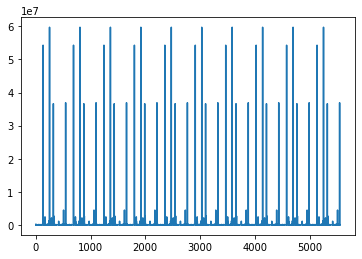

In [17]:
plt.plot(loss_values)